## VAE Toturial for Cifar10 Dataset

Ref to <https://github.com/lyeoni/pytorch-mnist-VAE/blob/master/pytorch-mnist-VAE.ipynb>

In [1]:
import os
import matplotlib.pylab as plt
import torch 
import torchvision
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
import torch.nn.functional as F
import math
import numpy as np

from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

In [2]:
transform = T.Compose(
    [
        T.ToTensor(),
#        T.Grayscale()
    ]
)
    
def load_data(batch_size=128, n_workers=4):
    
    original_training_ds = CIFAR10(root='data/', download=True, transform=transform)
    test_ds = CIFAR10(root='data/', train=False, transform=transform)
    
    torch.manual_seed(12345)
    n_train = int(len(original_training_ds)*0.9)
    n_val = len(original_training_ds) - n_train
    print("n_train: %s, n_val: %s, n_test: %s" % (n_train, n_val, len(test_ds)))
    
    training_ds, val_ds = random_split(original_training_ds, [n_train, n_val])
    
    training_dl = DataLoader(training_ds, batch_size=batch_size, 
                                     shuffle=True, num_workers=n_workers, pin_memory=True)
    val_dl = DataLoader(val_ds, batch_size=batch_size, 
                                     shuffle=False, num_workers=n_workers, pin_memory=True)
    test_dl = DataLoader(test_ds, batch_size=batch_size, 
                                     shuffle=False, num_workers=n_workers, pin_memory=True)
    
    return training_dl, val_dl, test_dl



In [3]:
training_dl, val_dl, test_dl = load_data()

Files already downloaded and verified
n_train: 45000, n_val: 5000, n_test: 10000


images.shape: torch.Size([128, 3, 32, 32])
max, min: tensor(1.) tensor(0.) torch.float32


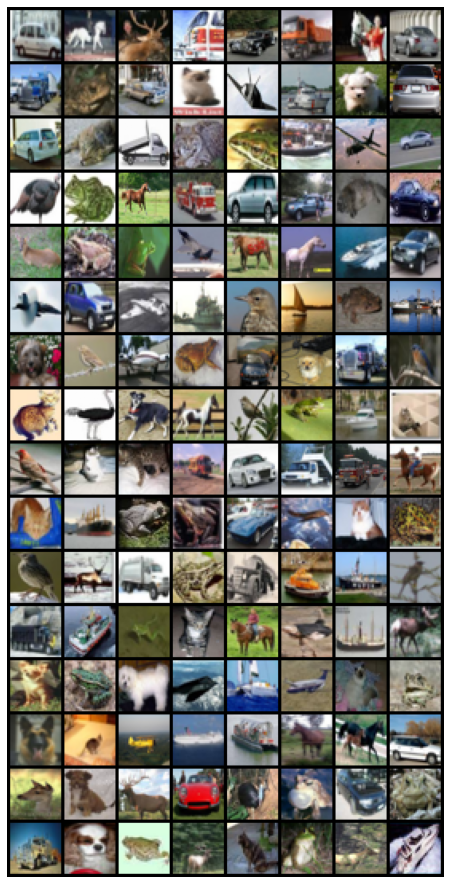

In [4]:
for images, _ in training_dl:
    print('images.shape:', images.shape)
    print('max, min:', torch.max(images), torch.min(images), images.dtype)
    plt.figure(figsize=(16,16))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

2359296


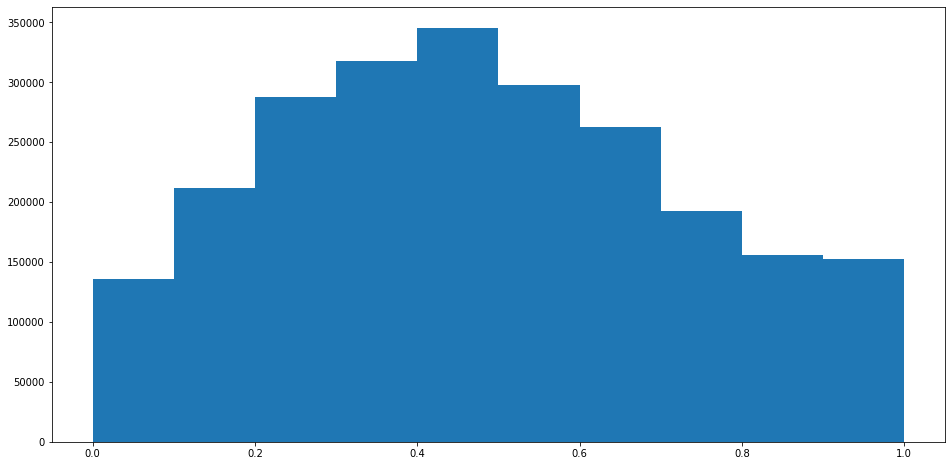

In [5]:
# Plot histogram of pixel value of datasets.
# Use 10 batches
pixels = []
for i, (images, _) in enumerate(training_dl):
    # images = torchvision.transforms.functional.rgb_to_grayscale(images)
    if i > 5:
        break
    pixels.append(images.flatten().cpu().numpy())
pixels = np.concatenate(pixels)
print(len(pixels))
plt.figure(figsize=(16,8))
_ = plt.hist(pixels, bins=10, range=(0.0, 1.0))

plt.show()

In [6]:
def get_device():
    env_device = os.environ.get('TORCH_DEVICE', "")
    print("TORCH_DEVICE: '%s'" % env_device)
    if env_device == "cpu":
        device = torch.device("cpu")
    elif env_device == "mps":
        device = torch.device("mps")
    else:
        device = torch.device("cuda" if torch.cuda.is_available()
                          else "mps" if torch.backends.mps.is_built() else "cpu")  # Select device for inference
    print("device: %s" % device)

    return device

#X_DIM = 3*32*32
Z_DIM = 100

class VAENet(torch.nn.Module):
    
    def __init__(self, z_dim):
        super(VAENet, self).__init__()
        
        # encoder part:
        self.encoder_block = torch.nn.Sequential()
       
        
        conv_block = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, kernel_size=3, stride=2, bias=False, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            #torch.nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
            #torch.nn.ReLU(), 
            # 16*16@16

            torch.nn.Conv2d(16, 32, kernel_size=3, stride=2, bias=False, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            #torch.nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            #torch.nn.ReLU(),    
            # 8*8@32

            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2, bias=False, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            #torch.nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            #torch.nn.ReLU(),     
            # 4*4@64

            torch.nn.Flatten(),           
            # 1024@1
            
        )
        self.encoder_block.append(conv_block)
        self.encoder_block.append(
            torch.nn.Sequential(
                torch.nn.Linear(1024, z_dim, bias=False),
                torch.nn.BatchNorm1d(z_dim),
                torch.nn.ReLU()
            )
        )

            
        self.mu_fc, self.log_var_fc  = \
            torch.nn.Linear(z_dim, z_dim), torch.nn.Linear(z_dim, z_dim)
    
    
        self.decoder_block = torch.nn.Sequential(
            torch.nn.Sequential(
                torch.nn.Linear(z_dim, z_dim, bias=False),
                torch.nn.BatchNorm1d(z_dim),
                torch.nn.ReLU()
            ),
            torch.nn.Sequential(
                torch.nn.Linear(z_dim, 1024, bias=False),
                torch.nn.BatchNorm1d(1024),
                torch.nn.ReLU()
            )
        )

        deconv_block = torch.nn.Sequential(
            torch.nn.Unflatten(1, [64, 4, 4]), # 4*4@64
            torch.nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),                  # 8*8@64
            #torch.nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1, output_padding=0),
            #torch.nn.ReLU(),                  # 8*8@32

            torch.nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),                  # 16*16@32
            #torch.nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1, output_padding=0),
            #torch.nn.ReLU(),                  # 16*16@16

            torch.nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            torch.nn.BatchNorm2d(3),
            torch.nn.ReLU(),                  # 32*32@16
            #torch.nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1, output_padding=0),
            #torch.nn.ReLU(),                  # 32*32@3                    
            
        )
        self.decoder_block.append(deconv_block)
        # self.decoder_last_fc = torch.nn.Linear(prev_dim, x_dim)
    
    def encode(self, x):
        h = x
        for l in self.encoder_block[0]:
            #print(l, h.shape)
            h = l(h)
        for l in self.encoder_block[1:]:
            #print(l, h.shape)
            h = l(h)
        #h = self.encoder_block(x)
    
        mu = self.mu_fc(h)
        log_var = self.log_var_fc(h)
        
        return mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(mu)
        
        return mu + std*eps
    
    def decode(self, z):
        h = z
        for l in self.decoder_block[:-1]:
            #print(l, h.shape)
            h = l(h)
        for l in self.decoder_block[-1]:
            #print(l, h.shape)
            h = l(h)
        #h = self.decoder_block(z)
        
        return torch.sigmoid(h)
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.sampling(mu, log_var)
        # rc_x: reconstructed x
        rc_x = self.decode(z)
        #print("mu, log_var, z, rc_x: ", mu.shape, log_var.shape, z.shape, rc_x.shape)
        
        return rc_x, mu, log_var

DEBUG_slot = dict()
def vae_loss_fn(x, rc_x, mu, log_var, alpha=10):
    # log(p(x|z))
    # bce_loss = F.binary_cross_entropy(rc_x, x, reduction="sum")
    # Use mse as reconstructed loss
    rc_loss = torch.mean(torch.sum(torch.pow(rc_x-x, 2), dim=(1,2,3)))
    DEBUG_slot['x'] = x.cpu()
    DEBUG_slot['rc_x'] = rc_x.cpu()    
    DEBUG_slot['rc_loss'] = rc_loss.cpu()
    
    kld_loss = torch.mean(-0.5*torch.sum(1 + log_var - torch.exp(log_var) - mu*mu, axis=1))
    DEBUG_slot['mu'] = mu
    DEBUG_slot['log_var'] = log_var
    DEBUG_slot['kld_loss'] = kld_loss
    
    loss = alpha*rc_loss +  kld_loss
    
    return loss, rc_loss, kld_loss
      

In [7]:
device = get_device()
print("device used: %s" % device)
vae = VAENet(z_dim=Z_DIM).to(device)
print(vae)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-04)
#optimizer = torch.optim.SGD(vae.parameters(), lr=0.001, momentum=0.9, weight_decay=0.005)

print(optimizer)

TORCH_DEVICE: ''
device: cuda
device used: cuda
VAENet(
  (encoder_block): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Flatten(start_dim=1, end_dim=-1)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=100, bias=False)
      (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (mu_fc): Linear(in_features=100, out_fea

In [14]:
def train(epoch):
    vae.train()
    loss_sum = 0.0
    rc_loss_sum = 0.0
    kld_loss_sum = 0.0

    for batch_idx, (x, _) in enumerate(training_dl):
        x = x.to(device)
        optimizer.zero_grad()
        
        rc_x, mu, log_var = vae(x)
        loss, rc_loss, kld_loss = vae_loss_fn(x, rc_x, mu, log_var)
        loss.backward()
        loss_sum += loss.item()
        rc_loss_sum += rc_loss.item()
        kld_loss_sum += kld_loss.item()
        optimizer.step()
        
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, RC loss: {:.6f}, KLD loss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(training_dl.dataset),
                100. * batch_idx / len(training_dl), 
                loss.item() / len(x), rc_loss.item()/len(x), 
                kld_loss.item()/len(x)))
            
    print('====> Epoch: {} Average loss: {:.4f}, RC loss: {:.4f}, KLD loss: {:.4f}'.format(
        epoch, loss_sum / len(training_dl.dataset), 
        rc_loss_sum / len(training_dl.dataset), 
        kld_loss_sum / len(training_dl.dataset)))

def val():
    vae.eval()
    loss_sum = 0
    rc_loss_sum = 0.0
    kld_loss_sum = 0.0
    
    with torch.no_grad():
        for x, _ in val_dl:
            x = x.to(device)
            rc_x, mu, log_var = vae(x)
            loss, rc_loss, kld_loss = vae_loss_fn(x, rc_x, mu, log_var)
            loss_sum += loss.item()
            rc_loss_sum += rc_loss.item()
            kld_loss_sum += kld_loss.item()
    
    print('====> Validation set loss: {:.4f}, RC loss: {:.4f}, KLD loss: {:.4f}'.format(
        loss_sum / len(val_dl.dataset), 
        rc_loss_sum / len(val_dl.dataset), 
        kld_loss_sum / len(val_dl.dataset)))
    
    
def test():
    vae.eval()
    loss_sum = 0
    rc_loss_sum = 0.0
    kld_loss_sum = 0.0
    
    with torch.no_grad():
        for x, _ in test_dl:
            x = x.to(device)
            rc_x, mu, log_var = vae(x)
            loss, rc_loss, kld_loss  = vae_loss_fn(x, rc_x, mu, log_var)
            loss_sum += loss.item()
            rc_loss_sum += rc_loss.item()
            kld_loss_sum += kld_loss.item()
    
    print('====> Test set loss: {:.4f}, RC loss: {:.4f}, KLD loss: {:.4f}'.format(
        loss_sum / len(test_dl.dataset), 
        rc_loss_sum / len(test_dl.dataset), 
        kld_loss_sum / len(test_dl.dataset)))


In [15]:
for epoch in range(1, 201):
    train(epoch)
    val()
test()

Train Epoch: 1 [0/45000 (0%)]	Loss: 10.225267, RC loss: 0.984871, KLD loss: 0.376556
Train Epoch: 1 [25600/45000 (57%)]	Loss: 9.679996, RC loss: 0.931372, KLD loss: 0.366273
====> Epoch: 1 Average loss: 9.9985, RC loss: 0.9624, KLD loss: 0.3745
====> Validation set loss: 10.2020, RC loss: 0.9813, KLD loss: 0.3892
Train Epoch: 2 [0/45000 (0%)]	Loss: 9.303884, RC loss: 0.893454, KLD loss: 0.369346
Train Epoch: 2 [25600/45000 (57%)]	Loss: 9.143542, RC loss: 0.877436, KLD loss: 0.369180
====> Epoch: 2 Average loss: 9.9929, RC loss: 0.9619, KLD loss: 0.3740
====> Validation set loss: 10.2042, RC loss: 0.9825, KLD loss: 0.3793
====> Test set loss: 9.9123, RC loss: 0.9537, KLD loss: 0.3753


tensor(0.9984) tensor(0.5000)
torch.Size([64, 3, 32, 32])


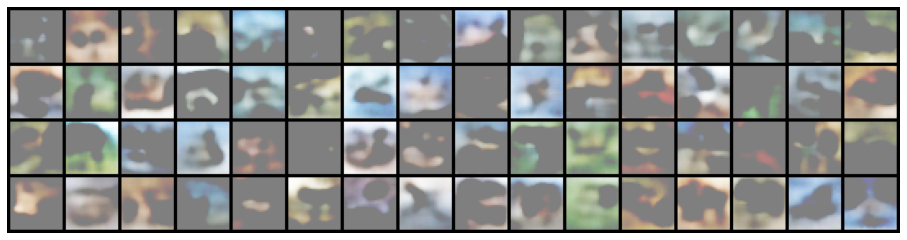

In [16]:
with torch.no_grad():
    z = torch.randn(64, Z_DIM).to(device)
    image_samples = vae.decode(z).cpu()
    print(torch.max(image_samples), torch.min(image_samples))
    image_samples = image_samples.reshape(64, 3, 32, 32)
    print(image_samples.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(image_samples, nrow=16).permute(1, 2, 0))    

In [11]:
DEBUG_slot['mu'].shape, DEBUG_slot['log_var'].shape

(torch.Size([16, 100]), torch.Size([16, 100]))

tensor(0.9997) tensor(0.5000)
torch.Size([128, 3, 32, 32])


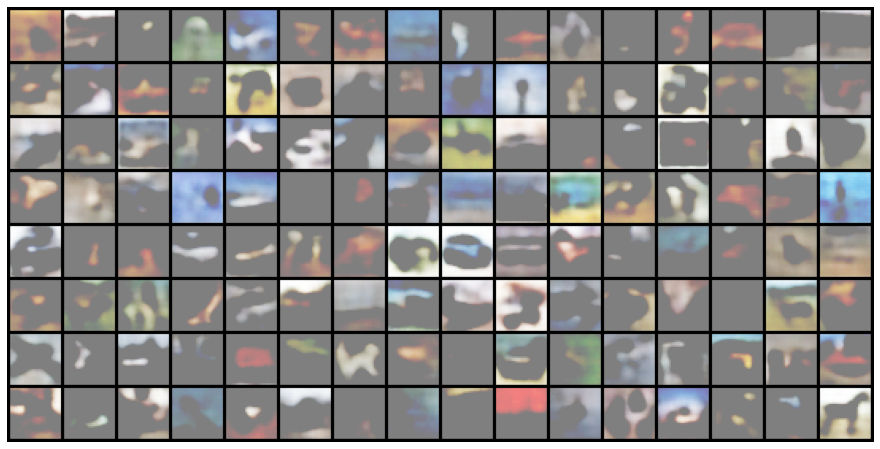

In [17]:
with torch.no_grad():
    for i, (images, _) in enumerate(training_dl):  
        if i >= 1:
            break
        #z = torch.randn(64, Z_DIM).to(device)
        mu, log_var = vae.encode(images.to(device))
        z = vae.sampling(mu, log_var)
        image_samples = vae.decode(z).cpu()
        print(torch.max(image_samples), torch.min(image_samples))
        image_samples = image_samples.reshape(z.shape[0], 3, 32, 32)
        print(image_samples.shape)
        plt.figure(figsize=(16,8))
        plt.axis('off')
        plt.imshow(make_grid(image_samples, nrow=16).permute(1, 2, 0))    
        